<a href="https://colab.research.google.com/github/Suryaprasadindra/research/blob/main/irish%2Chousing%2Clogistic%2Cxgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install xgboost


In [7]:
import numpy as np
from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.cluster import KMeans

def cluster_sampling_split(X, y, test_size=0.2, random_state=None, max_k=10):
    best_score = -np.inf if len(np.unique(y)) <= 3 else np.inf
    best_split = (None, None, None, None, None)

    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        clusters = kmeans.fit_predict(X)

        train_idx = []
        test_idx = []
        for cluster in np.unique(clusters):
            cluster_idx = np.where(clusters == cluster)[0]
            cluster_train_idx, cluster_test_idx = train_test_split(cluster_idx, test_size=test_size, random_state=random_state)
            train_idx.extend(cluster_train_idx)
            test_idx.extend(cluster_test_idx)

        np.random.shuffle(train_idx)
        np.random.shuffle(test_idx)

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LogisticRegression(max_iter=200) if len(np.unique(y)) <= 3 else RandomForestRegressor(random_state=random_state)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        score = accuracy_score(y_test, predictions) if isinstance(model, LogisticRegression) else mean_squared_error(y_test, predictions)

        if (isinstance(model, LogisticRegression) and score > best_score) or (isinstance(model, RandomForestRegressor) and score < best_score):
            best_score = score
            best_split = (X_train, X_test, y_train, y_test, k)

    if best_split[0] is None:  # If no valid split found, return a default random split
        return train_test_split(X, y, test_size=test_size, random_state=random_state) + (k,)
    return best_split

# Load datasets
iris = load_iris()
X_iris, y_iris = iris.data, iris.target
california = fetch_california_housing()
X_california, y_california = california.data, california.target

# Define models
models = {
    'classification': [LogisticRegression(max_iter=200), XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')],
    'regression': [RandomForestRegressor(random_state=42), XGBRegressor()]
}

def compare_sampling_methods(X, y, model, problem_type):
    result = cluster_sampling_split(X, y, test_size=0.2, random_state=42)
    if result[0] is None:  # Safely handle the case of no valid split
        return (None, None, None)

    X_train_custom, X_test_custom, y_train_custom, y_test_custom, best_k = result

    # Traditional random split for comparison
    X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train_custom, y_train_custom)
    pred_custom = model.predict(X_test_custom)

    model.fit(X_train_random, y_train_random)
    pred_random = model.predict(X_test_random)

    score_custom = accuracy_score(y_test_custom, pred_custom) if problem_type == 'classification' else mean_squared_error(y_test_custom, pred_custom)
    score_random = accuracy_score(y_test_random, pred_random) if problem_type == 'classification' else mean_squared_error(y_test_random, pred_random)

    return score_custom, score_random, best_k

# Test models
results = {}
for model in models['classification']:
    custom_score, random_score, best_k = compare_sampling_methods(X_iris, y_iris, model, 'classification')
    model_name = model.__class__.__name__
    results['Iris ' + model_name] = {'Custom Sampling': custom_score, 'Random Sampling': random_score, 'Best K': best_k}

for model in models['regression']:
    custom_score, random_score, best_k = compare_sampling_methods(X_california, y_california, model, 'regression')
    model_name = model.__class__.__name__
    results['California ' + model_name] = {'Custom Sampling': custom_score, 'Random Sampling': random_score, 'Best K': best_k}

# Output results
for dataset_model, scores in results.items():
    print(f"Dataset and Model: {dataset_model}")
    for method, score in scores.items():
        print(f"{method} Score: {score:.4f} (Best K: {scores['Best K']})" if method != 'Best K' else f"{method}: {score}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Dataset and Model: Iris LogisticRegression
Custom Sampling Score: 1.0000 (Best K: 5)
Random Sampling Score: 1.0000 (Best K: 5)
Best K: 5
Dataset and Model: Iris XGBClassifier
Custom Sampling Score: 0.9677 (Best K: 5)
Random Sampling Score: 1.0000 (Best K: 5)
Best K: 5
Dataset and Model: California RandomForestRegressor
Custom Sampling Score: 0.2319 (Best K: 10)
Random Sampling Score: 0.2554 (Best K: 10)
Best K: 10
Dataset and Model: California XGBRegressor
Custom Sampling Score: 0.2100 (Best K: 10)
Random Sampling Score: 0.2226 (Best K: 10)
Best K: 10


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8


Iris Dataset - Logistic Regression with Cluster Sampling
Confusion Matrix:
[[10  0  0]
 [ 0 11  0]
 [ 0  0 10]]


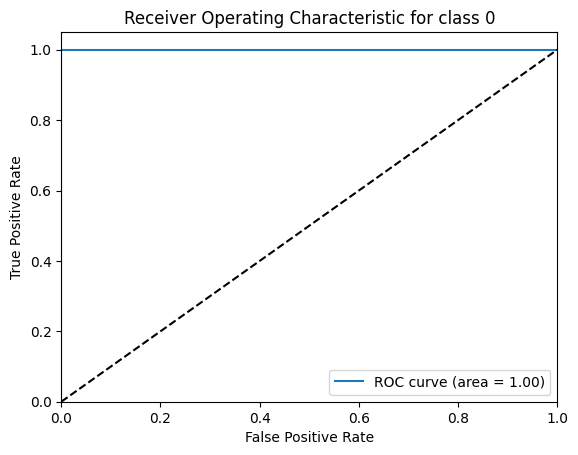

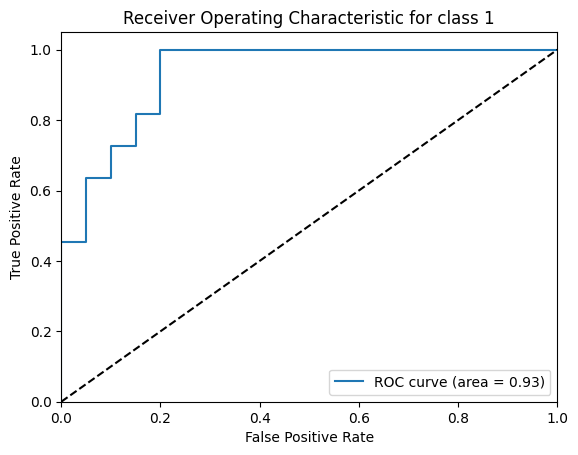

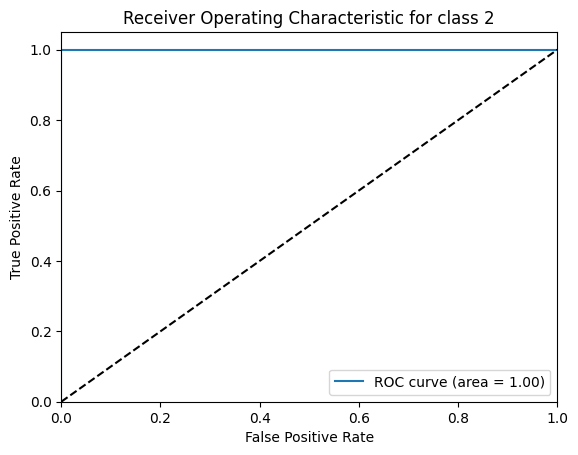


Iris Dataset - Logistic Regression with Random Sampling
Confusion Matrix:
[[ 9  0  0]
 [ 0 10  1]
 [ 0  1  9]]


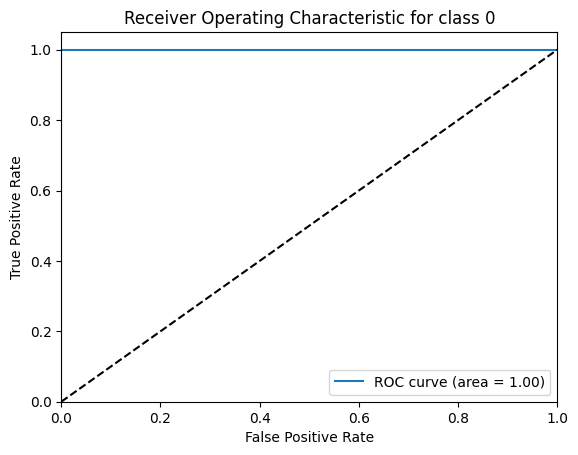

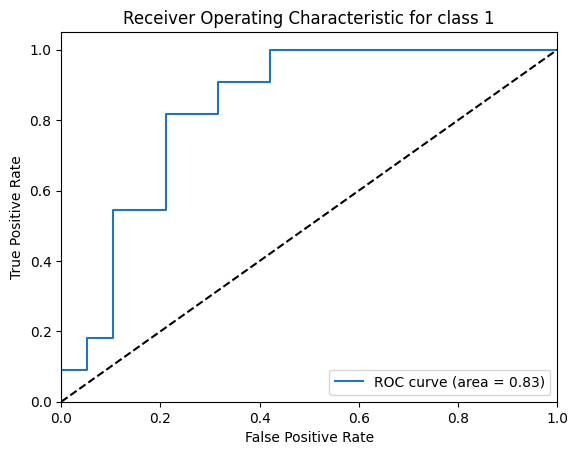

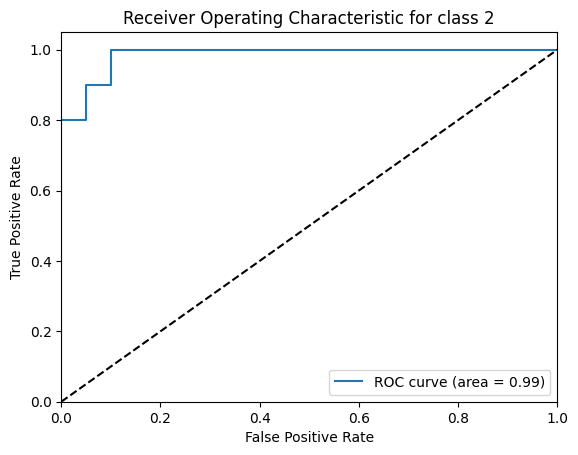


California Housing Dataset - XGBRegressor with Cluster Sampling
MSE: 0.20644310268319535
RMSE: 0.4543601024332961

California Housing Dataset - XGBRegressor with Random Sampling
MSE: 0.20669910788962925
RMSE: 0.45464173575424116


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

def perform_random_sampling(X, y, test_size=0.2, random_state=None):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def cluster_sampling_split(X, y, test_size=0.2, random_state=None, max_k=10):
    best_score = -np.inf if len(np.unique(y)) <= 3 else np.inf
    best_split = (None, None, None, None, None)

    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        clusters = kmeans.fit_predict(X)

        train_idx = []
        test_idx = []
        for cluster in np.unique(clusters):
            cluster_idx = np.where(clusters == cluster)[0]
            cluster_train_idx, cluster_test_idx = train_test_split(cluster_idx, test_size=test_size, random_state=random_state)
            train_idx.extend(cluster_train_idx)
            test_idx.extend(cluster_test_idx)

        np.random.shuffle(train_idx)
        np.random.shuffle(test_idx)

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LogisticRegression(max_iter=200) if len(np.unique(y)) <= 3 else RandomForestRegressor(random_state=random_state)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        score = accuracy_score(y_test, predictions) if isinstance(model, LogisticRegression) else mean_squared_error(y_test, predictions)

        if (isinstance(model, LogisticRegression) and score > best_score) or (isinstance(model, RandomForestRegressor) and score < best_score):
            best_score = score
            best_split = (X_train, X_test, y_train, y_test, k)

    return best_split if best_split[0] is not None else (X_train, X_test, y_train, y_test, k)

def display_metrics(X_train, X_test, y_train, y_test, predictions, problem_type):
    if problem_type == 'classification':
        cm = confusion_matrix(y_test, predictions)
        print("Confusion Matrix:")
        print(cm)

        y_bin = label_binarize(y_test, classes=np.unique(y_train))
        classifier = OneVsRestClassifier(LogisticRegression(max_iter=200))
        classifier.fit(X_train, label_binarize(y_train, classes=np.unique(y_train)))
        y_score = classifier.predict_proba(X_test)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        n_classes = y_bin.shape[1]
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.figure()
            plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic for class ' + str(i))
            plt.legend(loc="lower right")
            plt.show()
    else:
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        print("MSE:", mse)
        print("RMSE:", rmse)

# Load datasets
iris = load_iris()
X_iris, y_iris = iris.data, iris.target
california = fetch_california_housing()
X_california, y_california = california.data, california.target

# Simple Random Sampling
X_train_iris_rand, X_test_iris_rand, y_train_iris_rand, y_test_iris_rand = perform_random_sampling(X_iris, y_iris)
X_train_california_rand, X_test_california_rand, y_train_california_rand, y_test_california_rand = perform_random_sampling(X_california, y_california)

# Cluster Sampling
X_train_iris, X_test_iris, y_train_iris, y_test_iris, k_iris = cluster_sampling_split(X_iris, y_iris)
X_train_california, X_test_california, y_train_california, y_test_california, k_california = cluster_sampling_split(X_california, y_california)

# Evaluate Models for Iris Dataset - Logistic Regression
print("\nIris Dataset - Logistic Regression with Cluster Sampling")
model_iris = LogisticRegression(max_iter=200)
model_iris.fit(X_train_iris, y_train_iris)
predictions_iris = model_iris.predict(X_test_iris)
display_metrics(X_train_iris, X_test_iris, y_train_iris, y_test_iris, predictions_iris, 'classification')

print("\nIris Dataset - Logistic Regression with Random Sampling")
model_iris_rand = LogisticRegression(max_iter=200)
model_iris_rand.fit(X_train_iris_rand, y_train_iris_rand)
predictions_iris_rand = model_iris_rand.predict(X_test_iris_rand)
display_metrics(X_train_iris_rand, X_test_iris_rand, y_train_iris_rand, y_test_iris_rand, predictions_iris_rand, 'classification')

# Evaluate Models for California Housing Dataset - XGBRegressor
print("\nCalifornia Housing Dataset - XGBRegressor with Cluster Sampling")
model_california = XGBRegressor()
model_california.fit(X_train_california, y_train_california)
predictions_california = model_california.predict(X_test_california)
display_metrics(X_train_california, X_test_california, y_train_california, y_test_california, predictions_california, 'regression')

print("\nCalifornia Housing Dataset - XGBRegressor with Random Sampling")
model_california_rand = XGBRegressor()
model_california_rand.fit(X_train_california_rand, y_train_california_rand)
predictions_california_rand = model_california_rand.predict(X_test_california_rand)
display_metrics(X_train_california_rand, X_test_california_rand, y_train_california_rand, y_test_california_rand, predictions_california_rand, 'regression')
